# 🤗 Training Diffusion Models with Diffusers

> Diffusion Models은 복잡한 학습 및 추론 과정을 거쳐야 합니다.
> Object detection, segmentation처럼 Diffusion models도 framework이 존재합니다.
> Diffusers라는 framework을 사용해봅시다!
>
> https://github.com/huggingface/diffusers


## Installing the dependencies

> [🤗 Datasets](https://huggingface.co/docs/datasets/index): 다양한 Datasets를 쉽게 다운받을 수 있는 library.
>
> [🤗 Accelerate](https://huggingface.co/docs/accelerate/index): Multi-GPU, FP16, Gradient accumulation, logging등을 쉽게 해주는 library.


In [36]:
%%capture
!pip install diffusers[training]==0.11.1

> Hugging face에는 다양한 데이터셋, 모델 등을 정리해두었습니다.
> 다만, 이를 다운받기 위해서는 authentication token이 필요합니다.
> Huggingface를 처음 사용하시는 분들은 다음 링크에서 회원가입을 진행해주시면 되겠습니다.
>
> https://huggingface.co/join


In [37]:
from huggingface_hub import notebook_login

notebook_login()

## Config

> 학습에 필요한 대부분의 configuration들을 아주 간단하게 선언하고 사용할 수 있습니다.
> 대부분의 주요한 hyperparameter들을 정의할 수 있고 바꿔가면서 쉽게 실험할 수 있습니다.
> `number of epochs`, `batch size`, `learning rate` 등의 다양한 hyperparameter를 바꿔가며 실험해봅시다.

In [38]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # 이미지 해상도
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 10  # 50이면 꽤 괜찮은 이미지가 생성되지만 1시간 정도 소요됩니다.
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 100  # num_epochs가 50일 때는 비례하여 500으로 변경해주시면 됩니다.
    save_image_epochs = 10
    save_model_epochs = 10
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'  # 프로젝트 디렉토리 이름
    push_to_hub = False
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

mode = "DDIM" # DDPM, DDIM

## Loading the dataset

> [🤗 Datasets](https://github.com/huggingface/datasets) library를 통해서 `smithsonian_butterflies` 데이터셋을 다운받아 보도록 하겠습니다.
>
> Huggingface datasets에서는 다운로드도 지원하지만 데이터셋을 remote로 그때그때 받아서 학습하는 것 역시 지원합니다.
> 본 실습에서는 후자를 선택하도록 하겠습니다.

In [39]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

# Feel free to try other datasets from https://hf.co/huggan/ too!
# Here's is a dataset of flower photos:
# config.dataset_name = "huggan/flowers-102-categories"
# dataset = load_dataset(config.dataset_name, split="train")

# Or just load images from a local folder!
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, data_dir="path/to/folder")

Repo card metadata block was not found. Setting CardData to empty.


> 본 데이터셋에 있는 다양한 정보 중 `image`를 한 번 뽑아봅시다.

In [40]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

In [41]:
dataset[0]

{'image_url': 'https://ids.si.edu/ids/deliveryService?id=ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'image_alt': 'view Paper Kite digital asset number 1',
 'id': 'ark:/65665/m3b302800a43ef46b8a7a87a7b1eb06ab6',
 'name': 'Paper Kite',
 'scientific_name': 'Idea leuconoe',
 'gender': None,
 'taxonomy': 'Animalia, Arthropoda, Hexapoda, Insecta, Lepidoptera, Nymphalidae',
 'region': 'US Mid Atlantic (PA, NJ, MD, DE, DC, VA, WV)',
 'locality': 'NMNH Butterfly Pavilion, North America, United States, District of Columbia',
 'date': None,
 'usnm_no': 'EO401041',
 'guid': 'http://n2t.net/ark:/65665/35f90bc1d-2e3c-4798-a33c-611d7b358636',
 'edan_url': 'edanmdm:nmnheducation_11038234',
 'source': 'Smithsonian Education and Outreach collections',
 'stage': None,
 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x283>,
 'image_hash': 'fb0b8749d437efc70a26e54212b3572c',
 'sim_score': 0.8055200576782227}

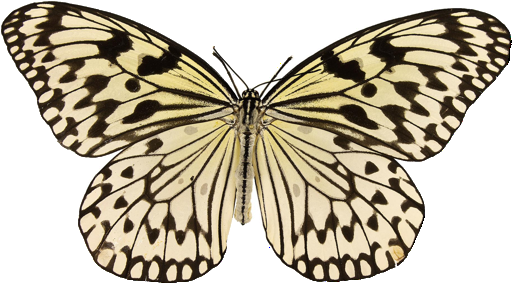

In [42]:
dataset[0]["image"]

In [43]:
dataset[0]["image"].size

(512, 283)

> [`Image`](https://huggingface.co/docs/datasets/image_process#image-datasets) 는 PIL.Image 형태로 불러와집니다.
> 확인해봅시다.

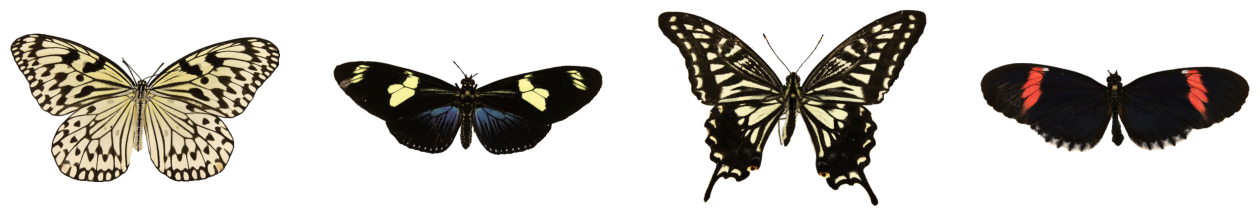

In [44]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

> 생성모델에서는 일반적으로 다음과 같은 이미지를 전처리 방식을 채택합니다.
>
> * `Resize`: 앞에서 정의한 `config.image_size`를 받아서 해당 크기로 resize 합니다.
> * `RandomHorizontalFlip`: 대부분의 이미지는 좌우를 바꾸어도 의미론적 손상이 없기 때문에 `RandomHorizontalFlip`은 효율적으로 데이터를 증강시킬 수 있는 방법 중 하나로 자주 쓰입니다.
> * `ToTensor`: `PIL.Image`의 구조인 이미지를 PyTorch에 맞는 형식인 `torch.Tensor`의 구조로 바꾸어주는 함수입니다.
> * `Normalize`: 이미지의 평균을 0으로 만들어주고 분산을 1근처로 만들어주기 위해서 사용되는 방법입니다.


In [45]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

> 🤗 Datasets에서 제공하는 `set_transform()` method를 이용하여 이미지를 전처리 합니다.

In [46]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

> 이미지가 어떻게 전처리 되었는지 확인해봅시다.
>
> 이제 앞으로 `dataset`에서 부르는 이미지는 항상 아래와 같이 전처리 되어 나오게 됩니다.

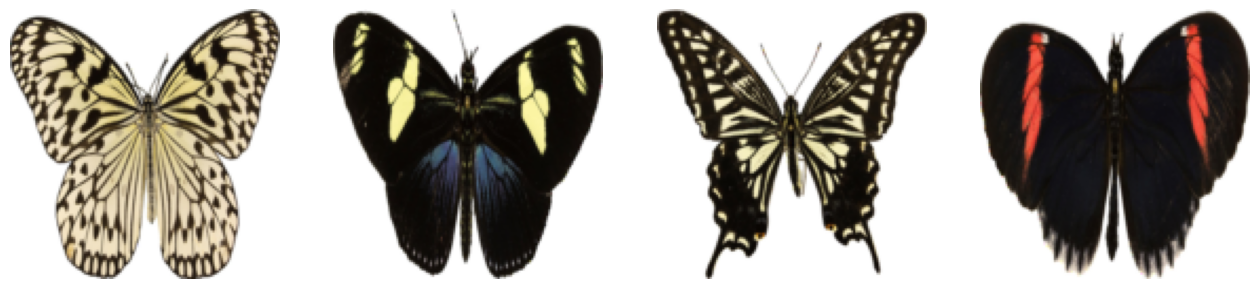

In [47]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

> (B, C, H, W)의 mini-batch를 구성하기 위해서는 이미지들이 모두 같은 H, W를 가져야 한다는 것을 알 수 있습니다.
>
> 이제 이미지가 전처리를 통해 모두 같은 크기를 가지게 된 덕분에 `DataLoader`에서 호출이 가능해졌으며 학습 역시 mini-batch 학습이 가능해졌습니다.


In [48]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Diffusion Models 정의

> Diffusion models는 복잡한 수식을 통해서 전개된 생성 모델이지만 간단하게 설명하면 아래 그림과 같이 결국 image와 같은 크기의 Gaussian noise부터 시작하여 점차 noise를 제거해 나가며 이미지를 생성하는 모델입니다.
>
> Diffusion models의 학습은 이미지에 임의의 noise를 끼웠다가 해당 noise를 제거하라는 목적 함수를 가지고 있습니다.
>
> 본 실습에서는 이 과정을 framework를 이용하여 간단하게 학습해 볼 것입니다.

<p align="center">
    <img src="https://user-images.githubusercontent.com/10695622/174349667-04e9e485-793b-429a-affe-096e8199ad5b.png" width="800"/>
    <br>
    <em> Figure from DDPM paper (https://arxiv.org/abs/2006.11239). </em>
<p>

> 우리가 최종적으로 학습할 것은 $p_{\theta}(x_{t-1}|x_{t})$이며 다음의 순서로 학습을 진행할 것입니다.
>
> 1. Training set에서 이미지를 한 장 가져옵니다.
> 2. 임의의 noise를 $t$번 뿌려서 $x_t$를 만들어 냅니다.
> 3. 우리의 diffusion model $\theta$에 $x_t$와 $t$를 입력으로 넣어줍니다.
> 4. 모델이 예측한 noise와 실제 뿌린 noise와의 차이를 계산하여 loss를 계산하고 모델을 학습시킵니다.
> 5. 1-4를 모델이 수렴할 때까지 반복합니다.


> 대부분의 diffusion models은 입력과 출력의 H, W가 동일하다는 특징을 고려하여 [U-net](https://arxiv.org/abs/1505.04597)의 구조를 가집니다.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

> Downsample block과 Upsample block은 residual connection을 가지는 ResNet의 구조를 가지며, 몇몇 layers에는 self-attention이 포함되어 있습니다.
>
> 큰 틀에서는 U-net의 구조를 갖지만 학습하는 데이터의 난이도에 따라서 아래와 같은 hyper-parameter를 쉽게 변경할 수 있습니다.
>
> * `type of layers`
> * `in_channels`
> * `out_channels`
> * `layers_per_block`
> * `block_out_channels`

In [49]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

> 이미지를 통과시켜보고 같은 크기의 출력이 나오는지 확인해봅시다.

In [50]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

Input shape: torch.Size([1, 3, 128, 128])


In [51]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


In [52]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Con

> 우리의 U-net 모델은 noisy한 입력 $x_t$를 받으며 이 $x_t$가 얼마나 noisy한지 힌트를 얻기 위해서 timestep $t$를 추가로 condition으로 받습니다.
>
> 이 과정에서 $t$는 하나의 scalar로 입력으로 받기보다는 transformers에서 자주 쓰이는 [sinusoidal positional embedding](https://arxiv.org/abs/1706.03762)을 진행하여 high dimension으로 만들어 준 후 입력으로 받습니다.


## Defining the noise scheduler

> 이제 우리는 noise를 추가하는 과정을 구현해보도록 하겠습니다.
>
> Noise를 timestep $t$만큼 추가하는데 그 정도를 조절하는 과정을 우리는 **noise scheduling**이라고 하며, 다양한 noise scheduling 방식은 `diffusers` library내에 모두 구현되어 있습니다.
> 우리는 그 중 `DDPMScheduler`라고 불리는 `diffusers`의 class를 써보도록 하겠습니다.


In [53]:
from diffusers import DDPMScheduler, DDIMScheduler
if mode == "DDPM":
    noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
else:
    noise_scheduler = DDIMScheduler(num_train_timesteps=1000)

> `noise_scheduler.add_noise`를 이용하여 이미지를 noising 해봅시다.

Original Image


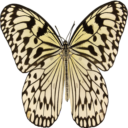

Noised Image


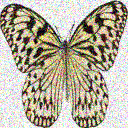

In [54]:
import torch
from PIL import Image
import torchvision

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([100]) # 노이즈의 정도
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

print('Original Image')
display(torchvision.transforms.ToPILImage()(sample_image[0].clamp(-1, 1)/2+.5))
print('Noised Image')
display(Image.fromarray(((noisy_image.permute(0, 2, 3, 1).clamp(-1, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0]))

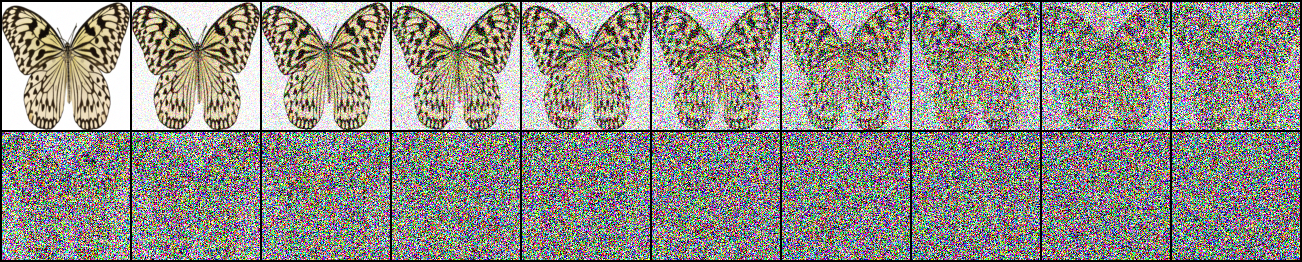

In [55]:
import torchvision
noisy_images = [noise_scheduler.add_noise(sample_image, torch.randn(sample_image.shape), t) for t in [torch.LongTensor([i]) for i in range(0, 1000, 50)]]
noisy_images = torchvision.transforms.ToPILImage()(torchvision.utils.make_grid((torch.cat(noisy_images) / 2 + 0.5).clamp(0, 1), nrow=10))
display(noisy_images)

> DDPM의 목적은 `noise_scheduler.add_noise`에서 사용되었던 `noise`를 예측하는 것입니다.
>
> 즉, `noisy_image`, `timesteps`를 입력으로 받아서 출력으로 `noise`가 나오도록 MSE loss를 걸어줘봅시다.

In [56]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1198, grad_fn=<MseLossBackward0>)


## Setting up training

> 모든 준비가 끝났습니다.
> AdamW 옵티마이저를 이용하여 학습을 진행해봅시다.
>
> AdamW: [Paper](https://arxiv.org/abs/1711.05101), [blog](https://hiddenbeginner.github.io/deeplearning/paperreview/2019/12/29/paper_review_AdamW.html)

In [57]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

> Learning rate scheduling으로는 warmup start와 더불어 cosine learning rate schedule을 사용할 것입니다.


In [58]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

> 평가를 위해서는 이미지를 뽑아봐야 하는데, 1000부터 0까지 denoising하는 pipeline 역시 `diffusers`에 구현되어 있습니다.
>
> `DDPMPipeline`을 사용해서 이미지를 sample 하는 코드는 다음과 같습니다.
>
> 우리는 뽑은 이미지를 grid의 형태로 만들어서 `test_dir`에 저장할 것입니다.

In [59]:
from diffusers import DDPMPipeline, DDIMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

> 이제 전체 `train_loop`를 짜보도록 하겠습니다.
>
> 🤗 Accelerate을 이용하여 기타 학습 환경 설정을 하도록 하겠습니다.
> 🤗 Accelerate library는 다음과 같은 작업이 가능합니다:
>
> - Logging을 위한 TensorBoard
> - 큰 batch_size를 작은 GPU에서 학습시키기 위한 Gradient accumulation
> - 효율적인 GPU 메모리 사용을 위한 mixed precision
> - Multi-GPUs or TPU를 이용한 학습


In [60]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            if mode =="DDPM":
              pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            else:
              pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

## Let's train!

> 학습을 진행해봅시다!
>
> Colab에서 학습을 진행하기 위해서는 `notebook_launcher`를 사용해야 합니다.
> 일반 서버에서 학습을 진행할 때에는 `python ...` 대신 `accelrate ...` 으로 프로그램을 시작하면 됩니다.

In [61]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

> 이제 샘플을 확인해봅시다.
>
> 학습 중간 중간에 사진을 저장하도록 하였으니 사진을 띄워 보는 것으로 대체합니다.

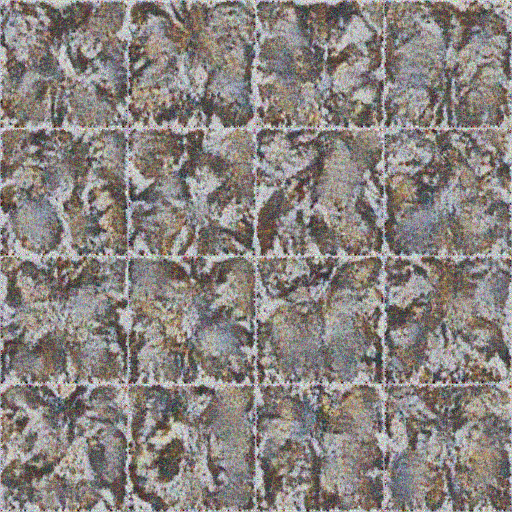

In [62]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

> 제한된 시간 상 나비 사진의 퀄리티가 좋지는 않습니다.
> 하지만 5배만 학습을 길게 하더라도 다음과 같은 퀄리티의 이미지를 얻을 수 있습니다!
> [5배 길게 학습한 실험 Link](https://huggingface.co/anton-l/ddpm-butterflies-128/tree/main)
>
> 앞의 configuration을 바꿔가며 실험해봅시다.

![](https://huggingface.co/anton-l/ddpm-butterflies-128/resolve/main/samples/0049.png)


## Conclusion

> DDPM을 비롯한 diffusion models는 간단한 학습 loss를 가지고 있으며, 큰 데이터도 모델링 할 수 있는 것으로 알려져 있습니다.
> 이러한 장점을 살려서 Stable Diffusion, DALL-E 2 등 거대 인공지능 회사에서 Text-to-image model을 diffusion models 구조를 기반으로 만들고 있습니다.
>
> 하지만, 다른 것 보다 DDPM의 sampling process 시간을 보면 U-net을 1000번 통과시키느라 굉장히 느린 것을 확인할 수 있습니다 (~2 min).
> 이 때문에 많은 연구자들이 sampling 속도를 빠르게 하는 연구를 진행했습니다. [DDIM](https://arxiv.org/abs/2010.02502)
>
> 이후로는 DDPM의 이론적 배경을 기반으로 한 Stable Diffusion에 대해서 알아보도록 하겠습니다.
